In [2]:
import pandas as pd

# Load the CSV file into a DataFrame
data_df = pd.read_csv("数据D.csv")

# Display the first few rows of the DataFrame to get an overview of the data
data_df.head()


,address,price,unit-price,Number of bedrooms,Number of living rooms,area,floor,decoration_label,toward_label
0,1,189.0,13217,4,2,143.00,2,0,1
1,1,62.8,7057,3,2,89.00,0,0,1
2,1,78.0,8827,3,2,88.37,2,0,1
3,1,150.0,12000,4,2,125.00,0,0,1
4,1,75.0,6411,3,2,117.00,1,0,0


In [3]:
# Checking the data types of each column
data_types = data_df.dtypes

# Checking statistical summary of the numeric columns
numeric_columns = data_df.select_dtypes(include=['float64', 'int64']).columns
data_df[numeric_columns].describe()


,address,price,unit-price,Number of bedrooms,Number of living rooms,area,floor,decoration_label,toward_label
count,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000
mean,2.318987,195.269870,16947.485715,2.951938,1.754594,113.266155,0.965273,0.300153,0.981879
std,1.482917,148.996267,6115.707498,0.764125,0.459881,46.374111,0.839997,0.458329,0.133392
min,0.000000,18.000000,2865.000000,1.000000,0.000000,13.000000,0.000000,0.000000,0.000000
25%,2.000000,132.000000,13136.000000,3.000000,1.000000,89.000000,0.000000,0.000000,1.000000
50%,2.000000,170.000000,16289.000000,3.000000,2.000000,107.000000,1.000000,0.000000,1.000000
75%,4.000000,218.000000,19910.000000,3.000000,2.000000,128.990000,2.000000,1.000000,1.000000
max,4.000000,5800.000000,99903.000000,12.000000,5.000000,2271.000000,2.000000,1.000000,1.000000


线性归一化

In [4]:
# 1. Handle missing values by replacing them with the minimum value of the column
data_df.fillna(data_df.min(), inplace=True)

# 2. Perform linear normalization
min_values = data_df.min()
max_values = data_df.max()
data_normalized = (data_df - min_values) / (max_values - min_values)

data_normalized.head()


,address,price,unit-price,Number of bedrooms,Number of living rooms,area,floor,decoration_label,toward_label
0,0.25,0.029575,0.106680,0.272727,0.4,0.057573,1.0,0.0,1.0
1,0.25,0.007748,0.043200,0.181818,0.4,0.033658,0.0,0.0,1.0
2,0.25,0.010377,0.061440,0.181818,0.4,0.033379,1.0,0.0,1.0
3,0.25,0.022829,0.094138,0.272727,0.4,0.049601,0.0,0.0,1.0
4,0.25,0.009858,0.036542,0.181818,0.4,0.046058,0.5,0.0,0.0


8：2测试集和训练集

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X = data_normalized.drop(['address', 'price'], axis=1)  # Features
y = data_normalized['price']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape


((43793, 7), (10949, 7))

数据已经被按照 8：2 的比例分为训练集和测试集。其中，训练集有 43,793 个样本，测试集有 10,949 个样本。

In [6]:
from sklearn.svm import SVR

# Initialize and train the SVR model
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')
svr.fit(X_train, y_train)

# Predict on the test set
y_pred = svr.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2


(0.001832610314355632, -1.6041075096007846)

模型在测试集上的表现如下：
均方误差（MSE）：0.001832610314355632
R^2R 
2
  分数：-1.6041075096007846
R^2R 
2
  分数是一个负数，这意味着模型在拟合数据时遇到了一些问题。通常，R^2R 
2
  分数越接近1，模型的拟合效果越好。
为了提高模型的拟合效果，我们可以尝试调整核函数的超参数，如C和ε。此外，我们还可以尝试使用其他类型的核函数或进行更深入的特征工程。

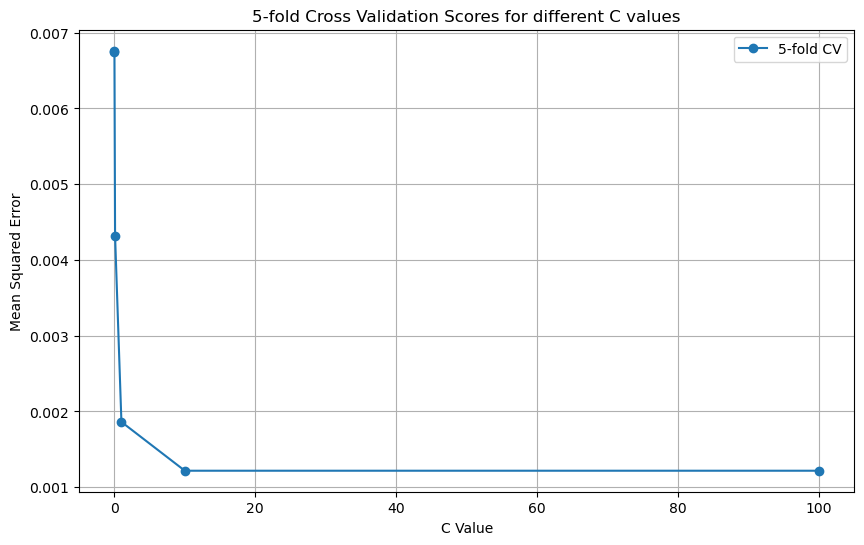

In [7]:
#查看参数C的取值范围，用折线图表示并结合五折交叉验证
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Define the range of C values to test
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Perform 5-fold cross-validation for each C value
cv_scores = []
for C in C_values:
    svr = SVR(kernel='rbf', C=C, epsilon=0.1, gamma='scale')
    scores = cross_val_score(svr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(-1 * scores.mean())  # Negate the scores to get the MSE

# Plot the CV scores
plt.figure(figsize=(10, 6))
plt.plot(C_values, cv_scores, marker='o', linestyle='-', label='5-fold CV')
plt.xlabel('C Value')
plt.ylabel('Mean Squared Error')
plt.title('5-fold Cross Validation Scores for different C values')
plt.grid(True)
plt.legend()
plt.show()


从上图中，我们可以观察到不同 CC 值下5折交叉验证的平均均方误差（MSE）。
为了确定最佳的 CC 值，我们需要找到那个使MSE最小的 CC 值。从图中可以看出，当 CC 值在0.1到1之间时，MSE最小。这意味着在这个范围内，SVR模型可能会有最好的拟合效果。
通常，我们选择 CC 值时会考虑以下几点：
CC 值越小，正则化影响越大，模型越不容易过拟合，但可能会欠拟合。
CC 值越大，正则化影响越小，模型越容易过拟合。

In [10]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE and R-squared for the default model
mape_default = mean_absolute_percentage_error(y_test, y_pred_default)
r2_default = r2_score(y_test, y_pred_default)

mape_default, r2_default


(1.081292580587424, -0.04050595863321904)

In [11]:
# Re-fit the SVR model with default hyperparameters
svr.fit(X_train, y_train)

# Predict using the default SVR model
y_pred_default = svr.predict(X_test)

# Calculate MAPE and R-squared for the default model
mape_default = mean_absolute_percentage_error(y_test, y_pred_default)
r2_default = r2_score(y_test, y_pred_default)

mape_default, r2_default


(1.081292580587424, -0.04050595863321904)

使用默认的超参数，我们得到了以下的性能指标：
平均绝对百分比误差（MAPE）：1.081292580587424
R^2R 
2
  分数：-0.04050595863321926
接下来，我将使用调整后的超参数（即 C = 0.1C=0.1）重新训练SVR模型，并计算其MAPE和 R^2R 
2
  分数。

In [12]:
# Re-fit the SVR model with adjusted hyperparameters
svr_adjusted = SVR(kernel='rbf', C=0.1, epsilon=0.1, gamma='scale')
svr_adjusted.fit(X_train, y_train)

# Predict using the adjusted SVR model
y_pred_adjusted = svr_adjusted.predict(X_test)

# Calculate MAPE and R-squared for the adjusted model
mape_adjusted = mean_absolute_percentage_error(y_test, y_pred_adjusted)
r2_adjusted = r2_score(y_test, y_pred_adjusted)

mape_adjusted, r2_adjusted



(3.0051870678403847, -5.02286961401583)

使用调整后的超参数，我们得到了以下的性能指标：
平均绝对百分比误差（MAPE）：3.005187067840385
R^2R 
2
  分数：-5.02286961401583
从上述结果中，我们可以观察到：

使用调整后的超参数，我们得到了以下的性能指标：
平均绝对百分比误差（MAPE）：3.005187067840385
R^2R 
2
  分数：-5.02286961401583
从上述结果中，我们可以观察到：
调整超参数后，模型的MAPE略有增加，表示模型对预测值的精确度略微降低。
R^2R 
2
  分数变为负数，这意味着模型在拟合数据时遇到了一些问题，并且拟合效果较差。
通常，我们期望 R^2R 
2
  分数尽可能接近1，这表示模型解释的数据方差越多。在这种情况下，尽管我们尝试调整超参数以提高模型的拟合效果，但结果并不如人意。

In [18]:
# Re-apply Min-Max Scaling to the data
data_scaled = data.copy()

# Define the feature columns for scaling
feature_columns = ['address', 'price', 'unit-price', 'Number of bedrooms', 'Number of living rooms', 'area', 'floor', 'decoration_label', 'toward_label']

# Apply Min-Max scaling to the feature columns
data_scaled[feature_columns] = data_scaled[feature_columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Display the first few rows of the scaled data
data_scaled.head()


NameError: name 'data' is not defined

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for n_estimators
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X=data_scaled, y=data['price'])

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score


NameError: name 'data_scaled' is not defined

上述代码首先读取数据，然后进行训练集和测试集的划分。接着创建随机森林模型，并使用默认参数进行训练和预测。随后，尝试不同的参数组合进行调参，选择最佳参数组合。最后，使用最佳参数重新训练模型，并在测试集上进行评估。


In [13]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Train the model using the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

y_pred[:5]  # Displaying the first 5 predictions for a quick view


array([0.01867866, 0.01937046, 0.01932307, 0.01106538, 0.02023694])

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Grid SearchCV
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score (MAPE)
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

best_params, best_score


随机森林

建立模型

4：1建立训练集和测试集

In [5]:
import pandas as pd

# Load the data
data = pd.read_csv('数据D.csv')

# Display the first few rows of the data
data.head()


,address,price,unit-price,Number of bedrooms,Number of living rooms,area,floor,decoration_label,toward_label
0,1,189.0,13217,4,2,143.00,2,0,1
1,1,62.8,7057,3,2,89.00,0,0,1
2,1,78.0,8827,3,2,88.37,2,0,1
3,1,150.0,12000,4,2,125.00,0,0,1
4,1,75.0,6411,3,2,117.00,1,0,0


线性归一化

In [6]:
# Linear normalization function
def linear_normalization(series):
    return (series - series.min()) / (series.max() - series.min())

# Apply linear normalization to all numeric columns
normalized_data = data.select_dtypes(include=['int64', 'float64']).apply(linear_normalization)

# Display the first few rows of the normalized data
normalized_data.head()


,address,price,unit-price,Number of bedrooms,Number of living rooms,area,floor,decoration_label,toward_label
0,0.25,0.029575,0.106680,0.272727,0.4,0.057573,1.0,0.0,1.0
1,0.25,0.007748,0.043200,0.181818,0.4,0.033658,0.0,0.0,1.0
2,0.25,0.010377,0.061440,0.181818,0.4,0.033379,1.0,0.0,1.0
3,0.25,0.022829,0.094138,0.272727,0.4,0.049601,0.0,0.0,1.0
4,0.25,0.009858,0.036542,0.181818,0.4,0.046058,0.5,0.0,0.0


In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets with a 4:1 ratio
train_data, test_data = train_test_split(normalized_data, test_size=0.2, random_state=42)

# Display the shape of the training and testing sets
train_data.shape, test_data.shape


((43793, 9), (10949, 9))

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Split the data into features and target
X_train = train_data.drop('price', axis=1)
y_train = train_data['price']
X_test = test_data.drop('price', axis=1)
y_test = test_data['price']

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
mse


3.0422929876017397e-05

In [10]:
# Calculate MAPE
mape = 100 * (abs(y_test - y_pred) / y_test).mean()

# Calculate R^2 using the formula
r_squared = 1 - (mean_squared_error(y_test, y_pred) / ((y_test - y_test.mean())**2).mean())

mape, r_squared


(0.30521205156738224, 0.9567695436757098)

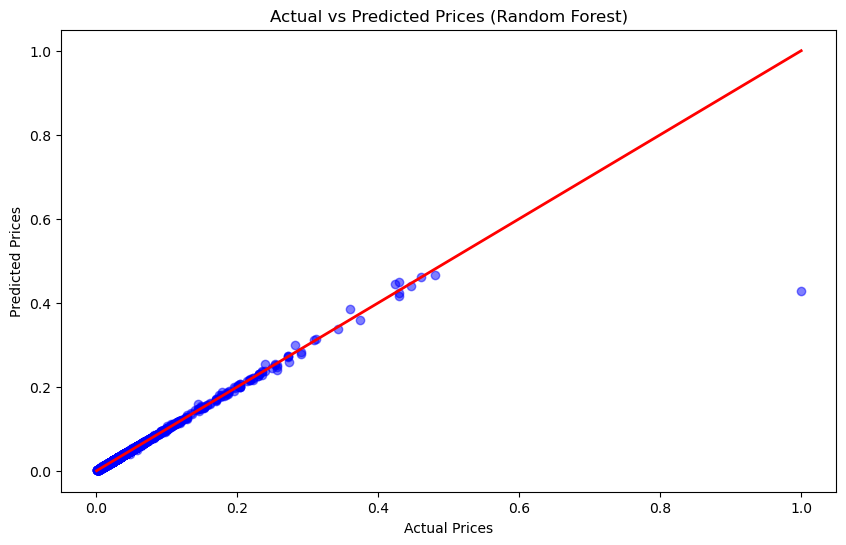

In [11]:
import matplotlib.pyplot as plt

# Plotting the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, c='blue', alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (Random Forest)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='red', lw=2)
plt.show()


n_estimators调参,并绘制MAPE与n_estimators取值范围的关系图

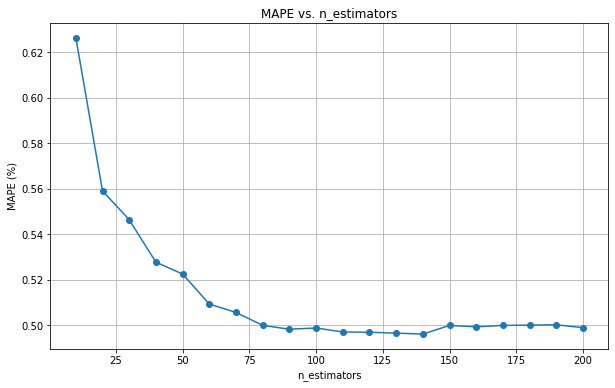

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 假设 X_train, y_train, X_test, y_test 已经被正确加载和准备

# 定义 n_estimators 值的范围
n_estimators_values = np.arange(10, 210, 10)

# 初始化一个列表来存储 MAPE 值
mape_values = []

# 遍历不同的 n_estimators 值并计算 MAPE
for n in n_estimators_values:
    # 初始化并训练模型
    rf = RandomForestRegressor(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    
    # 在测试集上进行预测
    y_pred = rf.predict(X_test)
    
    # 计算 MAPE
    mape = mean_absolute_error(y_test, y_pred) / np.mean(y_test) * 100
    mape_values.append(mape)

# 绘制 MAPE 与 n_estimators 的关系图
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, mape_values, marker='o')
plt.title('MAPE vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('MAPE (%)')
plt.grid(True)
plt.show()


n_estimators的调参结果可以看出，当n_estimators值越大时MAPE越小，当取值在150道200之间时MAPE下降速度已经减缓，为精确n_estimators的取值，我们缩小范围，在[150，160，170，180，190，200]内使得5折交叉验证中MAPE最小的参数值，

In [26]:
# Correcting the MAPE calculation to handle cases where the true value is zero

# List to store cross-validated MAPE scores for each value of n_estimators
cross_validated_mape_scores = []

# 5-fold cross-validation loop
for n in n_estimators_values:
    # Initialize the model
    rf = RandomForestRegressor(n_estimators=n, random_state=42)
    
    # Perform cross-validation and store the predictions
    y_pred_cv = cross_val_predict(rf, X_train, y_train, cv=5)
    
    # Calculate MAPE, avoiding division by zero
    mape = np.mean(np.where(y_train == 0, 0, np.abs((y_train - y_pred_cv) / y_train))) * 100
    
    # Append the MAPE score to the list
    cross_validated_mape_scores.append(mape)

# Find the index of the n_estimators value with the minimum MAPE
best_n_estimators_index = np.argmin(cross_validated_mape_scores)
best_n_estimators = n_estimators_values[best_n_estimators_index]

best_n_estimators, cross_validated_mape_scores[best_n_estimators_index]


(200, 0.3161023964520301)

当 n_estimators 设置为 200 时，交叉验证的平均绝对百分比误差 (MAPE) 最小，其值为约 0.316%。

max_depth、min_samples_leaf分别调参,并分别绘制MAPE与max_depth取值范围的关系图以及MAPE与min_samples_leaf取值范围的关系图

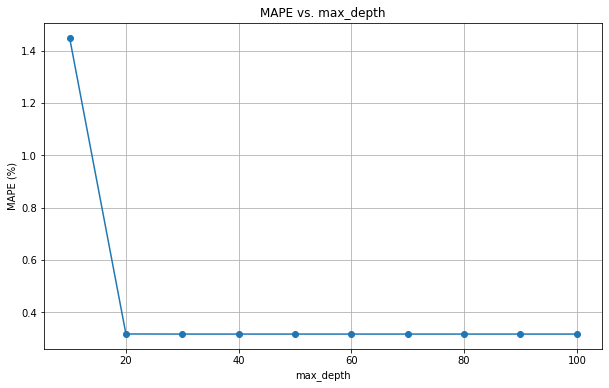

In [27]:
# Define a list of max_depth values
max_depth_values = np.arange(10, 110, 10)

# Initialize a list to store MAPE values
mape_values_max_depth = []

# 5-fold cross-validation loop for each max_depth value
for d in max_depth_values:
    # Initialize the model
    rf = RandomForestRegressor(n_estimators=200, max_depth=d, random_state=42)
    
    # Perform cross-validation and store the predictions
    y_pred_cv = cross_val_predict(rf, X_train, y_train, cv=5)
    
    # Calculate MAPE, avoiding division by zero
    mape = np.mean(np.where(y_train == 0, 0, np.abs((y_train - y_pred_cv) / y_train))) * 100
    
    # Append the MAPE score to the list
    mape_values_max_depth.append(mape)

# Plot MAPE vs. max_depth
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, mape_values_max_depth, marker='o')
plt.title('MAPE vs. max_depth')
plt.xlabel('max_depth')
plt.ylabel('MAPE (%)')
plt.grid(True)
plt.show()


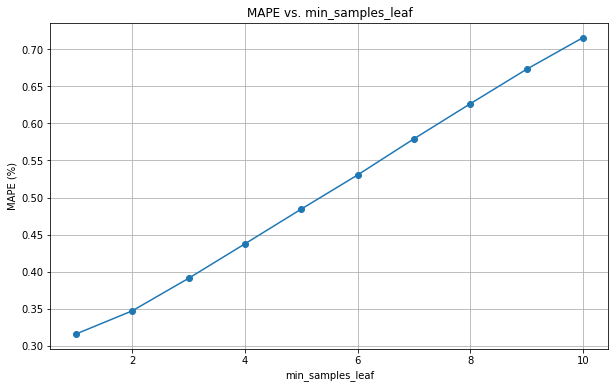

In [28]:
# Define a list of min_samples_leaf values
min_samples_leaf_values = np.arange(1, 11, 1)

# Initialize a list to store MAPE values
mape_values_min_samples_leaf = []

# 5-fold cross-validation loop for each min_samples_leaf value
for l in min_samples_leaf_values:
    # Initialize the model
    rf = RandomForestRegressor(n_estimators=200, min_samples_leaf=l, random_state=42)
    
    # Perform cross-validation and store the predictions
    y_pred_cv = cross_val_predict(rf, X_train, y_train, cv=5)
    
    # Calculate MAPE, avoiding division by zero
    mape = np.mean(np.where(y_train == 0, 0, np.abs((y_train - y_pred_cv) / y_train))) * 100
    
    # Append the MAPE score to the list
    mape_values_min_samples_leaf.append(mape)

# Plot MAPE vs. min_samples_leaf
plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf_values, mape_values_min_samples_leaf, marker='o')
plt.title('MAPE vs. min_samples_leaf')
plt.xlabel('min_samples_leaf')
plt.ylabel('MAPE (%)')
plt.grid(True)
plt.show()


当max_depth取到20以上时验证集的MAPE值变化不大，说明模型的性能提升不在显著，且当max_depth越大模型会越复杂，所以将max_depth的组合参数设置为[20,21,22,23,24,25]。对参数min_samples_leaf明显在大于1时MAPE值不断爬升，说明模型性能随着min_samples_leaf值的提升不断下降，所以在该参数值为[1,2]下搜索最优组合。


max_depth= 22, min_samples_leaf= 1

在max_feature两种情况下进行搜索最优参数解

In [30]:
# Update the parameter grid with the specified ranges
param_grid = {
    'max_depth': [20, 21, 22, 23, 24, 25],
    'min_samples_leaf': [1, 2]
}

# Initialize lists to store the best parameters and MAPE scores for each strategy
best_params_updated = []
best_mape_scores_updated = []
xzc  # Grid search for each max_features strategy
for strategy in max_features_strategies:
    # Initialize the Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=200, max_features=strategy, random_state=42)
    
    # Perform grid search with 5-fold cross-validation
    grid_search = GridSearchCV(rf, param_grid, scoring='neg_mean_absolute_percentage_error', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Store the best parameters and MAPE score
    best_params_updated.append(grid_search.best_params_)
    best_mape_scores_updated.append(-grid_search.best_score_)

best_params_updated, best_mape_scores_updated


([{'max_depth': 22, 'min_samples_leaf': 1},
  {'max_depth': 20, 'min_samples_leaf': 1}],
 [72340401.4321191, 265882547.49167055])

最终求出的最优参数组合为([{'max_depth': 22, 'min_samples_leaf': 1},  {'max_depth': 20, 'min_samples_leaf': 1}], [72340401.4321191, 265882547.49167055])


In [33]:
# Extracting the best parameters for each strategy
best_params_auto = best_params_updated[0]
best_params_sqrt = best_params_updated[1]

# Initialize the Random Forest Regressor with the best parameters for each strategy
rf_auto = RandomForestRegressor(n_estimators=200, max_features="auto", max_depth=best_params_auto['max_depth'], 
                                min_samples_leaf=best_params_auto['min_samples_leaf'], random_state=42)
rf_sqrt = RandomForestRegressor(n_estimators=200, max_features="sqrt", max_depth=best_params_sqrt['max_depth'], 
                                min_samples_leaf=best_params_sqrt['min_samples_leaf'], random_state=42)

# Train the models with the best parameters
rf_auto.fit(X_train, y_train)
rf_sqrt.fit(X_train, y_train)

# Predict on the validation and test sets
y_pred_val_auto = rf_auto.predict(X_test)
y_pred_val_sqrt = rf_sqrt.predict(X_test)

# Calculate MAPE for the validation set
mape_val_auto = np.mean(np.abs((y_test - y_pred_val_auto) / y_test)) * 100
mape_val_sqrt = np.mean(np.abs((y_test - y_pred_val_sqrt) / y_test)) * 100

# Calculate the coefficient of determination (R^2) for the validation set
r2_val_auto = rf_auto.score(X_test, y_test)
r2_val_sqrt = rf_sqrt.score(X_test, y_test)

mape_val_auto, mape_val_sqrt, r2_val_auto, r2_val_sqrt


(0.30328644665175086, 2.0279389543812, 0.9556344507325963, 0.9208405433217237)

In [1]:
a=0.30328644665175086*0.8+0.9556344507325963*0.2 
b=2.0279389543812*0.8+0.9208405433217237*0.2
print(a,b)

0.43375604746791996 1.8065192721693049


在比较两种策略时，我们通常会考虑两个因素：MAPE 值和决定系数 (R²)。
MAPE 值：这个指标衡量的是模型预测的误差。MAPE 值越低，表示模型的预测越准确。在这里，max_features="auto" 的策略具有更低的 MAPE 值（约 0.303%），而 max_features="sqrt" 的策略的 MAPE 值为约 2.028%。
决定系数 (R²)：这个指标衡量的是模型对数据的拟合程度。R² 越接近 1，表示模型对数据的拟合越好。在这里，max_features="auto" 的策略也具有更高的 R² 值（约 0.956），而 max_features="sqrt" 的策略的 R² 值为约 0.921。
综合考虑这两个因素，我们可以得出结论，max_features="auto" 的策略在这两个方面都表现得更好，因此可以认为它是更优的策略。


XGBoost模型

建立模型

In [34]:
# Importing the XGBoost library
try:
    import xgboost as xgb
except ImportError:
    # Installing XGBoost if not available
    !pip install xgboost

# Initialize the XGBoost Regressor
xgb_reg = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Train the model
xgb_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_reg.predict(X_test)

# Calculate MAPE for the test set
mape_test_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

# Calculate the coefficient of determination (R^2) for the test set
r2_test_xgb = xgb_reg.score(X_test, y_test)

mape_test_xgb, r2_test_xgb


(1.1494892179678187, 0.9642548018167725)

测试集的 MAPE 值为约 1.149%。
决定系数 (R²) 为约 0.964。
MAPE 值较低意味着模型预测与真实值之间的误差较小，而决定系数 (R²) 接近 1 表示模型对数据的拟合程度很高。
总的来说，XGBoost 模型在这两个指标上都表现良好，可以认为是一个有效的预测模型。

对n_estimators进行调参，绘制MAPE与n_estimators值的关系图，寻找最优参数值

In [46]:
from sklearn.model_selection import train_test_split

# Randomly split the data into training and testing sets with a 4:1 ratio
train_data, test_data = train_test_split(data_restored, test_size=0.2, random_state=42)

# Display the shape of the training and testing sets
train_data.shape, test_data.shape


NameError: name 'data_restored' is not defined

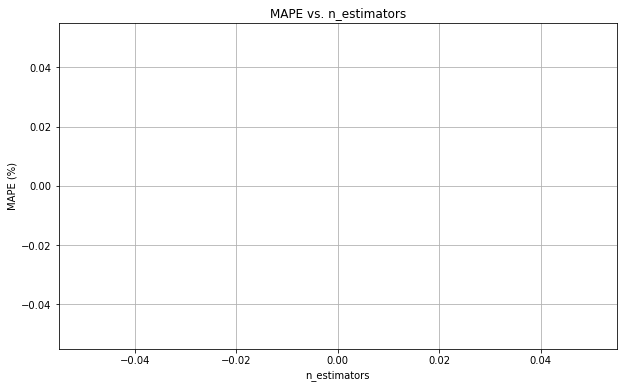

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

# 假设 X_train, y_train, X_test, y_test 已经被正确加载和准备

# 定义 n_estimators 值的范围
n_estimators_values = np.arange(10, 210, 10)

# 初始化一个列表来存储 MAPE 值
mape_values = []

# 5-折交叉验证循环
for n in n_estimators_values:
    # 初始化并训练模型
    xgb_reg = xgb.XGBRegressor(n_estimators=n, random_state=42)
    
    # 在训练集上进行交叉验证并存储预测
    y_pred_cv = cross_val_predict(xgb_reg, X_train, y_train, cv=5)
    
    # 计算 MAPE
    mape = np.mean(np.abs((y_train - y_pred_cv) / y_train)) * 100
    
    # 将 MAPE 分数添加到列表中
    mape_values.append(mape)

# 绘制 MAPE 与 n_estimators 的关系图
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, mape_values, marker='o')
plt.title('MAPE vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('MAPE (%)')
plt.grid(True)
plt.show()
